In [3]:
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
import os
import random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


from monai.transforms import (
    Compose, LoadImage, Resize, ScaleIntensity, ToTensor
)
from monai.networks.nets import UNet, AutoEncoder
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism

from sklearn.model_selection import train_test_split

from tqdm import tqdm

c:\Users\lucas\anaconda3\envs\monai-dev\Lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
DATA_ROOT = "./data"
SLICE_RANGE = [145, 291]

CHANNELS = (16, 32, 64, 128, 256)
STRIDES = (2, 2, 2, 2, 2)

IMG_SIZE = (256,256)

NBR_EPOCH_UNET = 50

BATCH_SIZE     = 4
NUM_WORKERS    = 0
N_EPOCHS       = 50
LR             = 1e-4
PATIENCE       = 10
MODEL_DIR      = "./base_unet_ckpt"
os.makedirs(MODEL_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
all_patients = sorted(os.listdir(DATA_ROOT))
random.seed(42)
random.shuffle(all_patients)

test_patients = all_patients[:1]
supervised_pool = all_patients[9:]

# Split supervised patients into train and val
train_patients, val_patients = train_test_split(supervised_pool, test_size=0.25, random_state=42)

print(f"Test: {test_patients}")
print(f"Supervised: {train_patients}")


Test: ['07040DORE']
Supervised: ['08002CHJE', '08027SYBR', '01038PAGU', '01016SACH']


In [6]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import re

class PngSlicesDataset(Dataset):
    """
    Dataset PyTorch pour charger des paires image/masque depuis des dossiers de slices PNG.
    Gère les cas avec ou sans masque (pré-entraînement ou entraînement supervisé).
    Prend en compte une liste explicite de patients.
    """
    def __init__(self, root_dir, with_mask=True, resized_size=(256, 256), slice_range=None, transform=None, patient_list=None):
        self.image_paths = []
        self.mask_paths = []
        self.patient_names = []
        self.resized_size = resized_size
        self.slice_range = slice_range
        self.with_mask = with_mask
        self.transform = transform if transform is not None else transforms.ToTensor()

        # Filtrer les patients selon la liste fournie
        all_patients = sorted(os.listdir(root_dir))
        patients = patient_list if patient_list is not None else all_patients

        for patient in patients:
            images_folder = os.path.join(root_dir, patient, "IRM")
            masks_folder = os.path.join(root_dir, patient, "masque")

            if not os.path.isdir(images_folder):
                continue
            if self.with_mask and not os.path.isdir(masks_folder):
                continue

            for img_file in sorted(os.listdir(images_folder)):
                match = re.match(r"slice_(\d+)\.png", img_file)
                if not match:
                    continue

                slice_num = int(match.group(1))
                if self.slice_range and not (self.slice_range[0] <= slice_num <= self.slice_range[1]):
                    continue

                img_path = os.path.join(images_folder, img_file)
                if self.with_mask:
                    mask_path = os.path.join(masks_folder, img_file)
                    if not os.path.exists(mask_path):
                        continue
                    self.mask_paths.append(mask_path)

                self.image_paths.append(img_path)
                self.patient_names.append(patient)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        resize = transforms.Resize(self.resized_size)
        img = resize(img)
        img = self.transform(img)
        img = (img - 0.5) / 0.5  # Normalisation [-1, 1]

        if self.with_mask:
            mask = Image.open(self.mask_paths[idx]).convert('L')
            mask = resize(mask)
            mask = self.transform(mask)
            mask = (mask > 0.5).float()
            return img, mask, self.image_paths[idx]
        else:
            return img, self.image_paths[idx]

    def get_patient_name(self, idx):
        return self.patient_names[idx]


In [7]:

# Création des datasets
train_dataset = PngSlicesDataset(DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=train_patients)
val_dataset = PngSlicesDataset(DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=val_patients)
test_dataset = PngSlicesDataset(DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=test_patients)


`len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Epoch 1/50


Train: 100%|██████████| 124/124 [00:11<00:00, 10.54it/s]


Train Loss: 0.9175


Val: 100%|██████████| 43/43 [00:03<00:00, 12.43it/s]


Val Loss: 0.9004 | Val Dice: 0.0797
💾 Model saved

Epoch 2/50


Train: 100%|██████████| 124/124 [00:10<00:00, 11.72it/s]


Train Loss: 0.8899


Val: 100%|██████████| 43/43 [00:03<00:00, 13.35it/s]


Val Loss: 0.8920 | Val Dice: 0.1289
💾 Model saved

Epoch 3/50


Train: 100%|██████████| 124/124 [00:10<00:00, 11.72it/s]


Train Loss: 0.8812


Val: 100%|██████████| 43/43 [00:03<00:00, 14.22it/s]


Val Loss: 0.8890 | Val Dice: 0.1618
💾 Model saved

Epoch 4/50


Train: 100%|██████████| 124/124 [00:10<00:00, 12.02it/s]


Train Loss: 0.8760


Val: 100%|██████████| 43/43 [00:03<00:00, 11.32it/s]


Val Loss: 0.8846 | Val Dice: 0.1855
💾 Model saved

Epoch 5/50


Train: 100%|██████████| 124/124 [00:25<00:00,  4.82it/s]


Train Loss: 0.8719


Val: 100%|██████████| 43/43 [00:08<00:00,  5.33it/s]


Val Loss: 0.8829 | Val Dice: 0.1937
💾 Model saved

Epoch 6/50


Train: 100%|██████████| 124/124 [00:23<00:00,  5.21it/s]


Train Loss: 0.8676


Val: 100%|██████████| 43/43 [00:03<00:00, 14.23it/s]


Val Loss: 0.8811 | Val Dice: 0.2063
💾 Model saved

Epoch 7/50


Train: 100%|██████████| 124/124 [00:10<00:00, 12.29it/s]


Train Loss: 0.8639


Val: 100%|██████████| 43/43 [00:02<00:00, 14.71it/s]


Val Loss: 0.8756 | Val Dice: 0.2167
💾 Model saved

Epoch 8/50


Train: 100%|██████████| 124/124 [00:10<00:00, 12.00it/s]


Train Loss: 0.8606


Val: 100%|██████████| 43/43 [00:03<00:00, 13.33it/s]


Val Loss: 0.8734 | Val Dice: 0.2305
💾 Model saved

Epoch 9/50


Train: 100%|██████████| 124/124 [00:10<00:00, 11.59it/s]


Train Loss: 0.8577


Val: 100%|██████████| 43/43 [00:03<00:00, 14.01it/s]


Val Loss: 0.8717 | Val Dice: 0.2518
💾 Model saved

Epoch 10/50


Train: 100%|██████████| 124/124 [00:10<00:00, 11.35it/s]


Train Loss: 0.8549


Val: 100%|██████████| 43/43 [00:03<00:00, 13.55it/s]


Val Loss: 0.8715 | Val Dice: 0.2512
💾 Model saved

Epoch 11/50


Train: 100%|██████████| 124/124 [00:11<00:00, 11.04it/s]


Train Loss: 0.8525


Val: 100%|██████████| 43/43 [00:03<00:00, 13.91it/s]


Val Loss: 0.8682 | Val Dice: 0.2536
💾 Model saved

Epoch 12/50


Train: 100%|██████████| 124/124 [00:10<00:00, 11.49it/s]


Train Loss: 0.8501


Val: 100%|██████████| 43/43 [00:02<00:00, 14.37it/s]


Val Loss: 0.8674 | Val Dice: 0.2577
💾 Model saved

Epoch 13/50


Train: 100%|██████████| 124/124 [00:18<00:00,  6.59it/s]


Train Loss: 0.8479


Val: 100%|██████████| 43/43 [00:08<00:00,  5.24it/s]


Val Loss: 0.8642 | Val Dice: 0.2764
💾 Model saved

Epoch 14/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.55it/s]


Train Loss: 0.8456


Val: 100%|██████████| 43/43 [00:08<00:00,  5.33it/s]


Val Loss: 0.8659 | Val Dice: 0.2729

Epoch 15/50


Train: 100%|██████████| 124/124 [00:23<00:00,  5.28it/s]


Train Loss: 0.8435


Val: 100%|██████████| 43/43 [00:07<00:00,  5.52it/s]


Val Loss: 0.8643 | Val Dice: 0.2906

Epoch 16/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.46it/s]


Train Loss: 0.8415


Val: 100%|██████████| 43/43 [00:08<00:00,  4.88it/s]


Val Loss: 0.8590 | Val Dice: 0.2855
💾 Model saved

Epoch 17/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.58it/s]


Train Loss: 0.8394


Val: 100%|██████████| 43/43 [00:06<00:00,  6.74it/s]


Val Loss: 0.8616 | Val Dice: 0.2849

Epoch 18/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.60it/s]


Train Loss: 0.8374


Val: 100%|██████████| 43/43 [00:08<00:00,  5.30it/s]


Val Loss: 0.8595 | Val Dice: 0.2904

Epoch 19/50


Train: 100%|██████████| 124/124 [00:21<00:00,  5.82it/s]


Train Loss: 0.8355


Val: 100%|██████████| 43/43 [00:06<00:00,  6.33it/s]


Val Loss: 0.8605 | Val Dice: 0.2863

Epoch 20/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.44it/s]


Train Loss: 0.8335


Val: 100%|██████████| 43/43 [00:08<00:00,  5.26it/s]


Val Loss: 0.8570 | Val Dice: 0.2982
💾 Model saved

Epoch 21/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.50it/s]


Train Loss: 0.8316


Val: 100%|██████████| 43/43 [00:06<00:00,  6.26it/s]


Val Loss: 0.8545 | Val Dice: 0.2955
💾 Model saved

Epoch 22/50


Train: 100%|██████████| 124/124 [00:21<00:00,  5.69it/s]


Train Loss: 0.8298


Val: 100%|██████████| 43/43 [00:07<00:00,  5.93it/s]


Val Loss: 0.8573 | Val Dice: 0.2908

Epoch 23/50


Train: 100%|██████████| 124/124 [00:23<00:00,  5.38it/s]


Train Loss: 0.8278


Val: 100%|██████████| 43/43 [00:07<00:00,  5.73it/s]


Val Loss: 0.8530 | Val Dice: 0.3041
💾 Model saved

Epoch 24/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.46it/s]


Train Loss: 0.8261


Val: 100%|██████████| 43/43 [00:07<00:00,  6.14it/s]


Val Loss: 0.8541 | Val Dice: 0.2866

Epoch 25/50


Train: 100%|██████████| 124/124 [00:21<00:00,  5.65it/s]


Train Loss: 0.8242


Val: 100%|██████████| 43/43 [00:06<00:00,  6.19it/s]


Val Loss: 0.8510 | Val Dice: 0.3022
💾 Model saved

Epoch 26/50


Train: 100%|██████████| 124/124 [00:23<00:00,  5.30it/s]


Train Loss: 0.8223


Val: 100%|██████████| 43/43 [00:07<00:00,  5.99it/s]


Val Loss: 0.8529 | Val Dice: 0.2842

Epoch 27/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.43it/s]


Train Loss: 0.8207


Val: 100%|██████████| 43/43 [00:07<00:00,  6.02it/s]


Val Loss: 0.8477 | Val Dice: 0.2986
💾 Model saved

Epoch 28/50


Train: 100%|██████████| 124/124 [00:24<00:00,  5.15it/s]


Train Loss: 0.8190


Val: 100%|██████████| 43/43 [00:06<00:00,  6.16it/s]


Val Loss: 0.8472 | Val Dice: 0.3017
💾 Model saved

Epoch 29/50


Train: 100%|██████████| 124/124 [00:23<00:00,  5.21it/s]


Train Loss: 0.8171


Val: 100%|██████████| 43/43 [00:06<00:00,  6.48it/s]


Val Loss: 0.8474 | Val Dice: 0.2861

Epoch 30/50


Train: 100%|██████████| 124/124 [00:19<00:00,  6.24it/s]


Train Loss: 0.8154


Val: 100%|██████████| 43/43 [00:07<00:00,  6.14it/s]


Val Loss: 0.8454 | Val Dice: 0.2906
💾 Model saved

Epoch 31/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.42it/s]


Train Loss: 0.8135


Val: 100%|██████████| 43/43 [00:06<00:00,  6.29it/s]


Val Loss: 0.8439 | Val Dice: 0.3063
💾 Model saved

Epoch 32/50


Train: 100%|██████████| 124/124 [00:23<00:00,  5.33it/s]


Train Loss: 0.8119


Val: 100%|██████████| 43/43 [00:07<00:00,  6.02it/s]


Val Loss: 0.8413 | Val Dice: 0.3033
💾 Model saved

Epoch 33/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.58it/s]


Train Loss: 0.8100


Val: 100%|██████████| 43/43 [00:06<00:00,  6.16it/s]


Val Loss: 0.8413 | Val Dice: 0.3016

Epoch 34/50


Train: 100%|██████████| 124/124 [00:23<00:00,  5.19it/s]


Train Loss: 0.8082


Val: 100%|██████████| 43/43 [00:08<00:00,  5.35it/s]


Val Loss: 0.8424 | Val Dice: 0.2905

Epoch 35/50


Train: 100%|██████████| 124/124 [00:26<00:00,  4.75it/s]


Train Loss: 0.8065


Val: 100%|██████████| 43/43 [00:07<00:00,  5.70it/s]


Val Loss: 0.8419 | Val Dice: 0.2900

Epoch 36/50


Train: 100%|██████████| 124/124 [00:24<00:00,  5.06it/s]


Train Loss: 0.8048


Val: 100%|██████████| 43/43 [00:08<00:00,  5.07it/s]


Val Loss: 0.8394 | Val Dice: 0.2986
💾 Model saved

Epoch 37/50


Train: 100%|██████████| 124/124 [00:22<00:00,  5.55it/s]


Train Loss: 0.8030


Val: 100%|██████████| 43/43 [00:08<00:00,  4.89it/s]


Val Loss: 0.8387 | Val Dice: 0.2939
💾 Model saved

Epoch 38/50


Train: 100%|██████████| 124/124 [00:19<00:00,  6.40it/s]


Train Loss: 0.8013


Val: 100%|██████████| 43/43 [00:07<00:00,  5.95it/s]


Val Loss: 0.8395 | Val Dice: 0.2937

Epoch 39/50


Train: 100%|██████████| 124/124 [00:26<00:00,  4.74it/s]


Train Loss: 0.7994


Val: 100%|██████████| 43/43 [00:06<00:00,  7.01it/s]


Val Loss: 0.8361 | Val Dice: 0.3010
💾 Model saved

Epoch 40/50


Train: 100%|██████████| 124/124 [00:26<00:00,  4.65it/s]


Train Loss: 0.7977


Val: 100%|██████████| 43/43 [00:08<00:00,  5.09it/s]


Val Loss: 0.8372 | Val Dice: 0.2917

Epoch 41/50


Train: 100%|██████████| 124/124 [00:21<00:00,  5.81it/s]


Train Loss: 0.7960


Val: 100%|██████████| 43/43 [00:07<00:00,  6.10it/s]


Val Loss: 0.8391 | Val Dice: 0.2876

Epoch 42/50


Train: 100%|██████████| 124/124 [00:21<00:00,  5.73it/s]


Train Loss: 0.7943


Val: 100%|██████████| 43/43 [00:07<00:00,  5.92it/s]


Val Loss: 0.8337 | Val Dice: 0.2941
💾 Model saved

Epoch 43/50


Train: 100%|██████████| 124/124 [00:23<00:00,  5.18it/s]


Train Loss: 0.7925


Val: 100%|██████████| 43/43 [00:06<00:00,  6.41it/s]


Val Loss: 0.8359 | Val Dice: 0.2933

Epoch 44/50


Train: 100%|██████████| 124/124 [00:19<00:00,  6.21it/s]


Train Loss: 0.7905


Val: 100%|██████████| 43/43 [00:06<00:00,  6.40it/s]


Val Loss: 0.8306 | Val Dice: 0.3036
💾 Model saved

Epoch 45/50


Train: 100%|██████████| 124/124 [00:12<00:00, 10.09it/s]


Train Loss: 0.7887


Val: 100%|██████████| 43/43 [00:02<00:00, 15.53it/s]


Val Loss: 0.8337 | Val Dice: 0.2908

Epoch 46/50


Train: 100%|██████████| 124/124 [00:09<00:00, 12.45it/s]


Train Loss: 0.7869


Val: 100%|██████████| 43/43 [00:03<00:00, 14.17it/s]


Val Loss: 0.8337 | Val Dice: 0.2882

Epoch 47/50


Train: 100%|██████████| 124/124 [00:11<00:00, 10.84it/s]


Train Loss: 0.7851


Val: 100%|██████████| 43/43 [00:03<00:00, 13.50it/s]


Val Loss: 0.8302 | Val Dice: 0.2993
💾 Model saved

Epoch 48/50


Train: 100%|██████████| 124/124 [00:16<00:00,  7.33it/s]


Train Loss: 0.7830


Val: 100%|██████████| 43/43 [00:02<00:00, 14.95it/s]


Val Loss: 0.8287 | Val Dice: 0.2855
💾 Model saved

Epoch 49/50


Train: 100%|██████████| 124/124 [00:10<00:00, 12.26it/s]


Train Loss: 0.7811


Val: 100%|██████████| 43/43 [00:02<00:00, 15.03it/s]


Val Loss: 0.8309 | Val Dice: 0.2801

Epoch 50/50


Train: 100%|██████████| 124/124 [00:09<00:00, 12.85it/s]


Train Loss: 0.7795


Val: 100%|██████████| 43/43 [00:02<00:00, 14.57it/s]
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Val Loss: 0.8273 | Val Dice: 0.2919
💾 Model saved


Test: 100%|██████████| 26/26 [00:02<00:00, 11.85it/s]



🎯 Test Dice: 0.0415


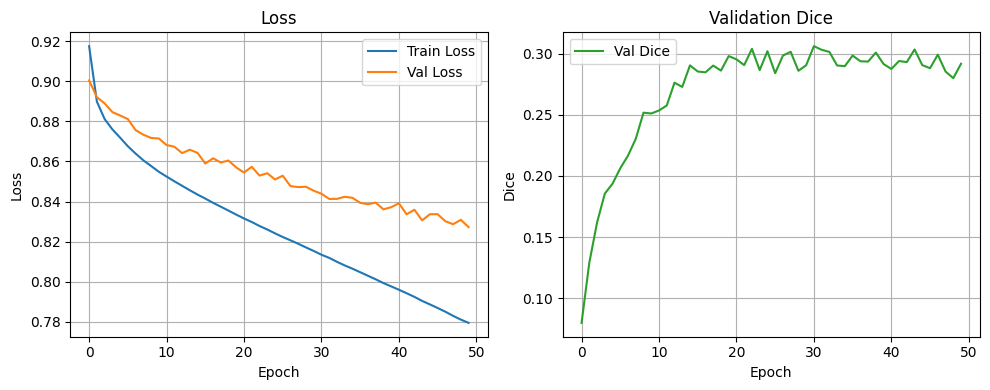

In [ ]:
%matplotlib inline

BATCH_SIZE_UNET = 4     # ajustez selon la VRAM dispo
NUM_WORKERS     = 0     # 0 en notebook, >0 sinon
# -------------------------
# 1) Datasets & Loaders
# -------------------------
train_ds = PngSlicesDataset(DATA_ROOT, with_mask=True,
    resized_size=IMG_SIZE, slice_range=SLICE_RANGE,
    patient_list=train_patients)
val_ds = PngSlicesDataset(DATA_ROOT, with_mask=True,
    resized_size=IMG_SIZE, slice_range=SLICE_RANGE,
    patient_list=val_patients)
test_ds = PngSlicesDataset(DATA_ROOT, with_mask=True,
    resized_size=IMG_SIZE, slice_range=SLICE_RANGE,
    patient_list=test_patients)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
    shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# -------------------------
# 2) Définition de ComboLoss
# -------------------------
class ComboLoss(nn.Module):
    def __init__(self, dice_weight=0.7, pos_weight=20.0):
        super().__init__()
        from monai.losses import DiceLoss
        self.dice_weight = dice_weight
        self.dice = DiceLoss(sigmoid=True)
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        pw = torch.tensor([self.pos_weight], device=inputs.device)
        bce = nn.BCEWithLogitsLoss(pos_weight=pw)(inputs, targets)
        dice = self.dice(inputs, targets)
        return self.dice_weight * dice + (1 - self.dice_weight) * bce

# -------------------------
# 3) Modèle, loss, optim, scheduler, métrique
# -------------------------
unet = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=CHANNELS,   # [16,32,64,...]
    strides=STRIDES,
    num_res_units=1
).to(DEVICE)

criterion = ComboLoss(dice_weight=0.7, pos_weight=20.0)
optimizer = torch.optim.AdamW(unet.parameters(), lr=LR, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode="min",
    patience=5, factor=0.5, verbose=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# -------------------------
# 4) Boucle d’entraînement / validation
# -------------------------
best_loss       = float('inf')
es_counter      = 0
PATIENCE_UNET   = 10
best_model_path = "best_unet_only.pth"

train_losses_unet = []
val_losses_unet   = []
val_dices_unet    = []

print(f"\n🔎 Train dataset : {len(train_dataset)} slices")
print(f"🔎 Val dataset   : {len(val_dataset)} slices")

for epoch in range(1, NBR_EPOCH_UNET+1):
    print(f"\n🚀 Epoch {epoch}/{NBR_EPOCH_UNET}")
    # — Training —
    unet.train()
    running_train = 0.0
    for imgs, masks, _ in tqdm(train_loader, desc="Train Batches"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        logits = unet(imgs)
        loss   = criterion(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train += loss.item()
    train_loss = running_train / len(train_loader)
    train_losses_unet.append(train_loss)
    print(f"[✓] Train Loss: {train_loss:.4f}")

    # — Validation —
    unet.eval()
    dice_metric.reset()
    running_val = 0.0
    with torch.no_grad():
        for imgs, masks, _ in tqdm(val_loader, desc="Val Batches"):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = unet(imgs)
            running_val += criterion(logits, masks).item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            dice_metric(y_pred=preds, y=masks)
    val_loss = running_val / len(val_loader)
    val_dice = dice_metric.aggregate().item()

    val_losses_unet.append(val_loss)
    val_dices_unet.append(val_dice)
    print(f"🔍 Val Loss: {val_loss:.4f}, Dice: {val_dice:.4f}")

    # scheduler & early stopping
    scheduler.step(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        es_cnt   = 0
        torch.save(unet.state_dict(), os.path.join(MODEL_DIR, "best_unet.pth"))
        print(f"💾 Saved best model (val_loss = {best_val:.4f})")
    else:
        es_cnt += 1
        if es_cnt >= PATIENCE_UNET:
            print(f"⏹ Early stopping (no improvement in {PATIENCE_UNET} epochs)")
            break

# -------------------------
# 5) Évaluation finale sur test
# -------------------------
unet.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_unet.pth")))
unet.eval()
dice_metric.reset()
with torch.no_grad():
    for imgs, masks, _ in tqdm(test_loader, desc="Test Batches"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = (torch.sigmoid(unet(imgs)) > 0.5).float()
        dice_metric(y_pred=preds, y=masks)
test_dice = dice_metric.aggregate().item()
print(f"\n🎯 Test Dice: {test_dice:.4f}")

# -------------------------
# 6) Tracé des courbes
# -------------------------
plt.figure(figsize=(8,4))
plt.plot(train_losses_unet, label="Train Loss")
plt.plot(val_losses_unet,   label="Val Loss")
plt.title("UNet Loss par Epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(val_dices_unet, label="Val Dice")
plt.title("UNet Dice par Epoch")
plt.xlabel("Epoch"); plt.ylabel("Dice")
plt.legend(); plt.grid(); plt.show()


Évaluation: 100%|██████████| 26/26 [00:02<00:00, 11.49it/s]



🎯 Dice moyen sur le test set : 0.1781 (sur 89 slices valides)


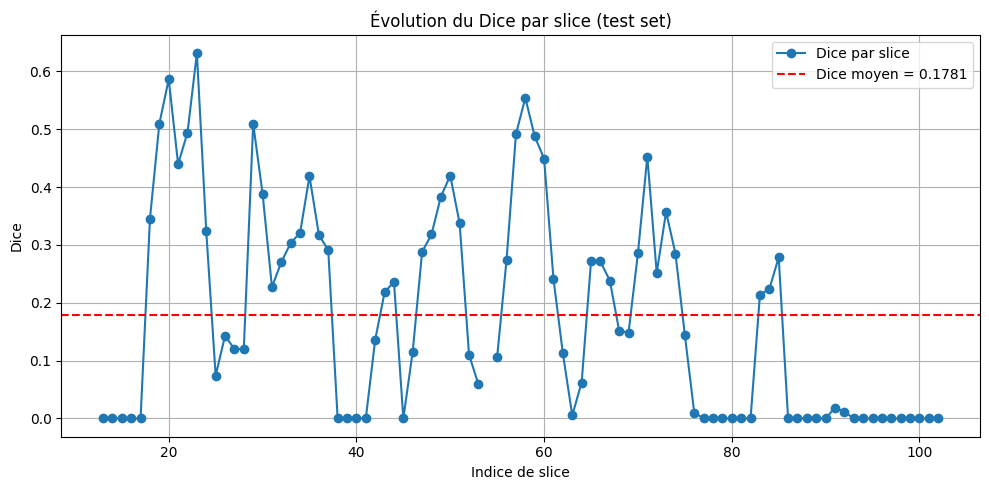

In [9]:
from monai.metrics import DiceMetric
import matplotlib.pyplot as plt
import numpy as np
import torch

# Initialisation du DiceMetric MONAI
dice_metric = DiceMetric(include_background=False, reduction="none")
dice_per_slice = []

unet.eval()
with torch.no_grad():
    for imgs, masks, _ in tqdm(test_loader, desc="Évaluation"):
        imgs, masks = imgs.cuda(), masks.cuda()

        # ✅ Application du Sigmoid sur la sortie brute
        outputs = torch.sigmoid(unet(imgs))

        # Calcul du Dice par slice
        batch_dice = dice_metric(y_pred=outputs, y=masks)  # shape: (batch_size,)
        dice_values = batch_dice.cpu().numpy().flatten().tolist()
        dice_per_slice.extend(dice_values)

# Nettoyage : exclusion des NaN (slices avec masque vide ou sortie plate)
dice_clean = [d for d in dice_per_slice if not np.isnan(d)]
mean_dice = np.mean(dice_clean) if dice_clean else 0.0

# ✅ Résumé global
print(f"\n🎯 Dice moyen sur le test set : {mean_dice:.4f} (sur {len(dice_clean)} slices valides)")

# 🔍 Tracé de l’évolution
plt.figure(figsize=(10, 5))
plt.plot(dice_per_slice, label="Dice par slice", marker='o')
plt.axhline(mean_dice, color='r', linestyle='--', label=f"Dice moyen = {mean_dice:.4f}")
plt.xlabel("Indice de slice")
plt.ylabel("Dice")
plt.title("Évolution du Dice par slice (test set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Reset du DiceMetric
dice_metric.reset()


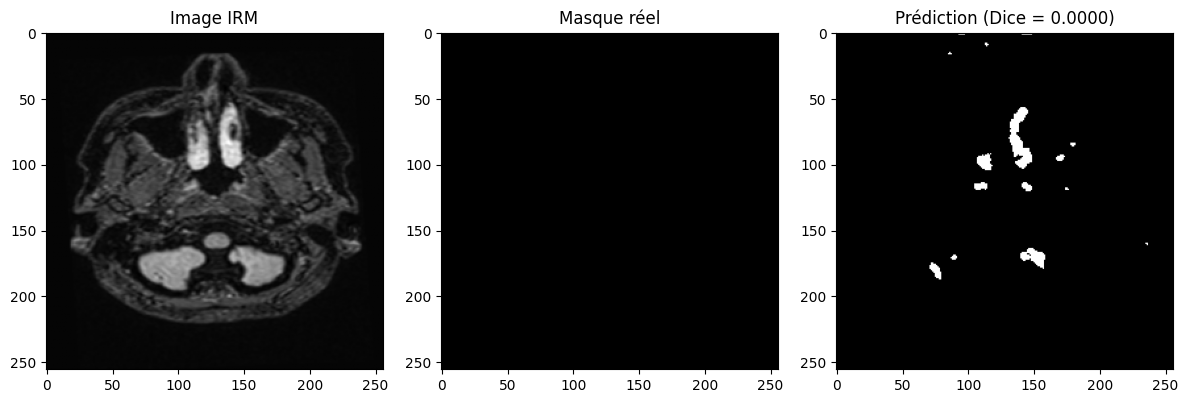

In [10]:
# Visualisation d'une image avec son score
imgs, masks, paths = next(iter(test_loader))
imgs, masks = imgs.cuda(), masks.cuda()
with torch.no_grad():
    outputs = unet(imgs)
    outputs_sigmoid = torch.sigmoid(outputs)
    preds = (outputs_sigmoid > 0.5).float()

    # Dice local (sur cette image uniquement)
    dice_local = DiceMetric(include_background=False, reduction="mean")
    dice_local(preds, masks)
    score_slice = dice_local.aggregate().item()

# Visualisation
img_np = imgs[0].cpu().squeeze().numpy()
mask_np = masks[0].cpu().squeeze().numpy()
pred_np = preds[0].cpu().squeeze().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np, cmap="gray")
plt.title("Image IRM")

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap="gray")
plt.title("Masque réel")

plt.subplot(1, 3, 3)
plt.imshow(pred_np, cmap="gray")
plt.title(f"Prédiction (Dice = {score_slice:.4f})")

plt.tight_layout()
plt.show()